In [1]:
import pandas as pd
import numpy as np
import re
import stat as st
import statistics as ss
import matplotlib as mat
import seaborn as sea
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [2]:
df=pd.read_csv('properatti.csv', sep = ",")     ### La parte de Robert es dfOrig, la llamo df como la parte de Paul

In [3]:
pd.options.display.max_colwidth = 1000

In [4]:
df.columns

Index(['Unnamed: 0', 'operation', 'property_type', 'place_name',
       'place_with_parent_names', 'country_name', 'state_name', 'geonames_id',
       'lat-lon', 'lat', 'lon', 'price', 'currency',
       'price_aprox_local_currency', 'price_aprox_usd', 'surface_total_in_m2',
       'surface_covered_in_m2', 'price_usd_per_m2', 'price_per_m2', 'floor',
       'rooms', 'expenses', 'properati_url', 'description', 'title',
       'image_thumbnail'],
      dtype='object')

Voy a trabajar con las descripciones. Genero un dataframe separado llamado desc y relleno las 2 descripciones vacias por un string "Descripcion vacia" para evitar errores relacionados con el type del contenido. Voy a extraer información que complemente a las columnas de:

Precio
Superficie Total
N° de piso
N° de habitaciones
Amenities
Country?

In [5]:
desc = df["description"]
desc = desc.fillna("Descripcion vacia")

Genero el pattern encargado de buscar precios de las propiedades en la descripcion.

Busco el signo "$" seguido de numeros (/d) con puntos (.) y espacios (/s) opcionales.

Ubicaciones posibles de los puntos: 10.000, 100.000, 1.000.000, 10.000.000, 100.000.000

In [6]:
pattern_precio = r"\$\s?\d\.?\d\.?\d\.?\d\.?\d\.?\d?\.?\d?\.?\d?\.?"
regex_precio = re.compile(pattern_precio)

In [7]:
precios_desc = []
for i in range (0, desc.shape[0]):
    match = regex_precio.findall(desc[i])
    if(len(match)>0):
             precios_desc.append(max(match).replace("$", "").replace(".", "").strip())
    else:
            precios_desc.append(None)

In [8]:
df["precios_desc"] = precios_desc
mask_precios = np.isnan(df.price) & (df.precios_desc.apply(lambda x: x is not None))

In [9]:
df[mask_precios][["price", "precios_desc"]].sample(10)

,price,precios_desc
2456,NaN,250000
25493,NaN,14300
2770,NaN,150000
61011,NaN,135131
102232,NaN,400000
40120,NaN,16200
12991,NaN,950000
77672,NaN,21034
25534,NaN,33200
120097,NaN,1800000


Busco metros cuadrados totales en las descripciones.

In [10]:
pattern_m2 = r"(\d+?\s?m2)"
regex_m2 = re.compile(pattern_m2, re.IGNORECASE)

In [11]:
m2_desc = []
for i in range (0, desc.shape[0]):
    match = regex_m2.findall(desc[i])
    if(len(match)>0):
            m2_desc.append(max(match).replace("m2", "").strip()) 
    else:
            m2_desc.append(None)

In [12]:
df["m2_desc"] = m2_desc

In [13]:
mask = np.isnan(df.surface_total_in_m2) & (df.m2_desc.apply(lambda x: x is not None))

In [14]:
df[mask][["surface_total_in_m2", "m2_desc"]].sample(5)

,surface_total_in_m2,m2_desc
119937,NaN,69
64751,NaN,68
33777,NaN,47
29003,NaN,36
47881,NaN,49


Intento identificar el numero de piso

In [15]:
pattern_piso = r"piso\s?n?\°?\:?\s?(\d+)"
regex_piso = re.compile(pattern_piso, re.IGNORECASE)

In [16]:
piso_desc = []
for i in range (0, desc.shape[0]):
    match = regex_piso.search(desc[i])
    if match:
        posibles_piso = (int(match.group(1)))
        if posibles_piso < 100:
            piso_desc.append(posibles_piso)
        else: 
            piso_desc.append(None)
    else:
          piso_desc.append(None)

In [17]:
df["piso_desc"] = piso_desc

In [18]:
mask = np.isnan(df.floor) & (df.piso_desc.apply(lambda x: ~np.isnan(x)))
df[mask][["floor", "piso_desc"]].shape

(4397, 2)

In [19]:
df[mask][["floor", "piso_desc"]].sample(10)

,floor,piso_desc
15872,NaN,6.0
48111,NaN,17.0
57263,NaN,4.0
81806,NaN,15.0
47885,NaN,12.0
114790,NaN,7.0
50992,NaN,6.0
94997,NaN,11.0
84468,NaN,18.0
109625,NaN,2.0


In [20]:
pattern_rooms = r"(\d)\s?ambi?e?n?t?e?s?"
regex_rooms = re.compile(pattern_rooms, re.IGNORECASE)

In [21]:
rooms_desc = []
for i in range (0, desc.shape[0]):
    match = regex_rooms.search(desc[i])
    if match:
        posibles = (int(match.group(1)))
        if posibles < 10:
            rooms_desc.append(posibles)
        else: 
            rooms_desc.append(None)
    else:
          rooms_desc.append(None)

In [22]:
df["rooms_desc"] = rooms_desc

In [23]:
mask_rooms = np.isnan(df.rooms) & (df.rooms_desc.apply(lambda x: ~np.isnan(x)))

In [24]:
df[mask_rooms][["rooms", "rooms_desc"]].sample(10)

,rooms,rooms_desc
100532,NaN,2.0
70276,NaN,4.0
28720,NaN,3.0
44999,NaN,3.0
113673,NaN,2.0
74114,NaN,3.0
87005,NaN,2.0
105747,NaN,3.0
101949,NaN,2.0
83497,NaN,2.0


Busco informacion extra.
En particular, si tienen pileta, sum, gimnasio, cochera o si es una casa, si esta dentro de un country.

Busco pileta o piscina

In [25]:
pattern_pileta = r"(pileta)|(piscina)"
regex_pileta = re.compile(pattern_pileta, re.IGNORECASE)

In [26]:
pileta = []
for i in range (0, desc.shape[0]):
    match = regex_pileta.findall(desc[i])
    if(len(match)>0):
             pileta.append(1) 
    else:
            pileta.append(None)

In [27]:
df["pileta"] = pileta

Busco si tienen SUM o Salon de eventos

In [28]:
pattern_salon = r"(sum)|(sal[oó]n de eventos)"
regex_salon = re.compile(pattern_salon, re.IGNORECASE)

In [29]:
salon = []
for i in range (0, desc.shape[0]):
    match = regex_salon.findall(desc[i])
    if(len(match)>0):
             salon.append(1) 
    else:
            salon.append(None)

In [30]:
df["salon"] = salon

In [31]:
pattern_gym = r"(gimna[sc]io)|(gym)"
regex_gym = re.compile(pattern_gym, re.IGNORECASE)

In [32]:
gym = []
for i in range (0, desc.shape[0]):
    match = regex_gym.findall(desc[i])
    if(len(match)>0):
             gym.append(1) 
    else:
            gym.append(None)

In [33]:
df["gym"] = gym

Tiene cochera

In [34]:
pattern_cochera = r"cochera"
regex_cochera = re.compile(pattern_cochera, re.IGNORECASE)

In [35]:
cochera = []
for i in range (0, desc.shape[0]):
    match = regex_cochera.findall(desc[i])
    if(len(match)>0):
             cochera.append(1) 
    else:
            cochera.append(None)

In [36]:
df["cochera"] = cochera

Esta la propiedad en un barrio cerrado/country?

In [37]:
pattern_country = r"(country)|(barrio cerrado)"
regex_country = re.compile(pattern_country, re.IGNORECASE)

In [38]:
country = []
for i in range (0, desc.shape[0]):
    match = regex_country.findall(desc[i])
    if(len(match)>0):
             country.append(1) 
    else:
            country.append(None)

In [39]:
df["country"] = country

Deptos super completos

In [40]:
tiene_pileta = df.pileta == 1
tiene_gym = df.gym == 1
tiene_salon = df.salon == 1
tiene_cochera = df.cochera == 1


df['completo'] = np.where((df['pileta']==1) & (df['gym']==1) & (df['salon']==1) & (df['cochera']==1), 1, 0)

In [41]:
mascara = df.completo == 1
df[mascara].shape

(3385, 36)

In [42]:
dfGeoNames=pd.ExcelFile('GeonamesAR.xlsx')    ## Abro libro excel con Geolocalizaciones de Argentina
dfGNames=dfGeoNames.parse('Geonames_AR')     ## Creo un df con planilla donde se encuentra geolocalizaciones - nombres localidades
dfGNames.set_index(dfGNames['geonameid'], inplace=True)    ### indizo por geolocalización

In [43]:
df=pd.merge(df,dfGNames, how='left', left_on='geonames_id', right_index=True )   ## join

In [44]:
## descarto columnas que no se van a usar
df.drop(['modification_date','timezone','dem','elevation','population','admin1_code','admin2_code','cc2'], axis=1, inplace=True)
df.drop(['asciiname','alternatenames','latitude','longitude','feature_class','feature_code','country_code', 'geonameid'], axis=1, inplace=True)
## renombro columnas que quedan
df.rename(index=str, columns={'name':'nameGeoPos', 'admin3_code':'provGeoPos', 'admin4_code':'localGeoPos'}, inplace=True)

In [45]:
### Para averiguar hasta cuantas columnas va a tener el nuevo DataFrame con Places
dfLocs=df['place_with_parent_names'].drop_duplicates()   ## lista sin duplicados de todas las localidades
lista=[sublista.split('|') for sublista in dfLocs]

maxLenLista=0    ### Seteo máximo en 0 (cero)
for i, lList in enumerate(lista):
    lList.remove('')   ## elimina la primera ocurrencia
    if lList[-1]=='':
        lList.pop()   ## el último si es vacío lo elimina
    largoLista=len(lList)
    if largoLista>maxLenLista:
        maxLenLista=largoLista

print(maxLenLista)

5


In [46]:
## Spliteo de place_with_parent_names y asignación a columnas
df['local1']=''    #### 3er lugar de la lista en place_with_parent_names
df['local2']=''    #### 4to lugar de la lista en place_with_parent_names
df['discard']=False  #### variable False registro queda, True se descarta, se inicializa con False

In [47]:
## Para reasignar series en el DF
for i in df.index:   
    lista =df.place_with_parent_names[i].split('|')
    lista.remove('')   ## elimina la primera ocurrencia, elemento vac
    if lista[-1]=='':
        lista.pop()   ## si el último es vacío lo elimina también
    state=lista[1]
    local1=''
    local2=''
    local3=''
    try:
        local1=lista[2]
        local2=lista[3]
        local3=lista[4]
    except:
        pass
    if local1 == '':
        if ((df.geonames_id[i]==3435907.0) or (df.geonames_id[i] == np.nan)):
            df.loc[i,'discard']=True     #### El 3435907 es geoname de Buenos Aires
        else:
            if df.geonames_id[i] != np.nan:
                df.loc[i,'discard']=True          
            else:
                df.loc[i,'place_name']=df.nameGeoPos[i]  # si no es NAN, asigna localidad de Geoposicion
    else:
        if local2 == '':
            df.loc[i,'place_name']=local1.strip()     ### si no tiene 4t0 elemento, place_name está en local1
        else:
            if local3 == '':
                df.loc[i,'local1']=local1.strip()   ### si no tiene 5t0 elemento, place_name está en local1 
                df.loc[i,'place_name']=local2.strip()   ## y reasigno el último con local2
            else:
                df.loc[i,'local1']=local1.strip()  
                df.loc[i,'local2']=local2.strip()  
                df.loc[i,'place_name']=local3.strip()   


In [48]:
df[['state_name','local1','local2','place_name','place_with_parent_names', 'discard']]

,state_name,local1,local2,place_name,place_with_parent_names,discard
0,Capital Federal,,,Mataderos,|Argentina|Capital Federal|Mataderos|,False
1,Bs.As. G.B.A. Zona Sur,,,La Plata,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|,False
2,Capital Federal,,,Mataderos,|Argentina|Capital Federal|Mataderos|,False
3,Capital Federal,,,Liniers,|Argentina|Capital Federal|Liniers|,False
4,Buenos Aires Costa Atlántica,Mar del Plata,,Centro,|Argentina|Buenos Aires Costa Atlántica|Mar del Plata|Centro|,False
5,Entre Ríos,,,Gualeguaychú,|Argentina|Entre Ríos|Gualeguaychú|,False
6,Bs.As. G.B.A. Zona Norte,Vicente López,,Munro,|Argentina|Bs.As. G.B.A. Zona Norte|Vicente López|Munro|,False
7,Capital Federal,,,Belgrano,|Argentina|Capital Federal|Belgrano|,False
8,Capital Federal,,,Belgrano,|Argentina|Capital Federal|Belgrano|,False
9,Santa Fe,,,Rosario,|Argentina|Santa Fe|Rosario|,False


In [49]:
df.discard.describe()    

count     121220
unique         2
top        False
freq      116440
Name: discard, dtype: object

In [50]:
### registros que podrían recuperarse trabajando con lat-lon
df[df.discard & ~df['lat-lon'].isnull()]['discard'].value_counts()

True    1352
Name: discard, dtype: int64

In [51]:
### Pongo en 0 los Geonames_id que son Nan para convertir la variable en entero
df['geonames_id'].fillna(0.0, inplace=True)
df['geonames_id']=df['geonames_id'].astype('int64', inplace=True)

In [52]:
#df.to_csv('properatti2.csv', sep=';', index=False, encoding='UTF-8')   ### guardo cambios temporales

In [53]:
dfpivot=df[~df.discard].pivot_table('operation', index='place_with_parent_names', columns='property_type',
                                  aggfunc='count', margins=True, margins_name='Total Unidades', 
                                  fill_value='')
dfpivot.sort_values(by='Total Unidades', ascending=False)

property_type,PH,apartment,house,store,Total Unidades
place_with_parent_names,,,,,
Total Unidades,5664,67999,38854,3923,116440
|Argentina|Santa Fe|Rosario|,66,7434,839,165,8504
|Argentina|Córdoba|Córdoba|,330,3919,2040,317,6606
|Argentina|Buenos Aires Costa Atlántica|Mar del Plata|,471,4457,1426,180,6534
|Argentina|Bs.As. G.B.A. Zona Norte|Tigre|Nordelta|,2,2086,1221,6,3315
|Argentina|Capital Federal|Belgrano|,43,2761,121,67,2992
|Argentina|Capital Federal|Palermo|,104,2599,70,112,2885
|Argentina|Bs.As. G.B.A. Zona Norte|Tigre|,1,586,1759,13,2359
|Argentina|Capital Federal|Caballito|,78,2079,78,38,2273


In [54]:
def hastaLocal (x):    ### Junta en una sola variable state y localidad, que puede estar en place_name o local1
    fullname = x['state_name']+'|'
    if x['local1']=='':
        fullname = fullname+x['place_name']
    else:
        fullname = fullname+x['local1']
    return fullname

In [55]:
df['state_local_name'] = df.apply(hastaLocal, axis = 1)


In [56]:
dfpivot=df[~df.discard].pivot_table('operation', index='state_local_name', columns='property_type',
                                  aggfunc='count', margins=True, margins_name='Total Unidades', fill_value='')
dfpivot.sort_values(by='Total Unidades', ascending=False)

property_type,PH,apartment,house,store,Total Unidades
state_local_name,,,,,
Total Unidades,5664,67999,38854,3923,116440
Bs.As. G.B.A. Zona Norte|Tigre,23,4090,4814,56,8983
Santa Fe|Rosario,66,7434,839,165,8504
Buenos Aires Costa Atlántica|Mar del Plata,510,5360,1616,224,7710
Córdoba|Córdoba,330,3919,2040,317,6606
Capital Federal|Palermo,132,3677,121,153,4083
Bs.As. G.B.A. Zona Norte|Vicente López,351,2052,1154,106,3663
Bs.As. G.B.A. Zona Sur|Lomas de Zamora,192,1448,1615,215,3470
Bs.As. G.B.A. Zona Sur|La Plata,187,1585,1454,134,3360


In [57]:
mask=dfpivot['Total Unidades']<3
local_2_o_menos_prop=dfpivot[mask].index     ### Serie con las localidades con 2 o menos propiedades, 
local_2_o_menos_prop #.value_counts

Index(['Buenos Aires Costa Atlántica|Mar de Cobo',
       'Buenos Aires Costa Atlántica|Pehuen-có',
       'Buenos Aires Costa Atlántica|Reta',
       'Buenos Aires Interior|Coronel Dorrego',
       'Buenos Aires Interior|General Alvear',
       'Buenos Aires Interior|General Belgrano',
       'Buenos Aires Interior|General Lavalle',
       'Buenos Aires Interior|General Paz',
       'Buenos Aires Interior|General Pinto',
       'Buenos Aires Interior|J A de la Peña',
       ...
       'Santa Fe|Sunchales', 'Santa Fe|Susana', 'Santa Fe|Venado Tuerto',
       'Santa Fe|Álvarez', 'Santiago Del Estero|Pinto',
       'Tucumán|Banda del Río Salí', 'Tucumán|Concepción',
       'Tucumán|Las Talitas', 'Tucumán|Lules', 'Tucumán|Villa Belgrano'],
      dtype='object', name='state_local_name', length=203)

In [58]:
def locali_no_esta(x):
    esta= x.state_local_name in local_2_o_menos_prop
    return (x.discard or esta )
    

In [59]:
df.discard=df.apply(locali_no_esta, axis=1 )   
df.discard.value_counts()            ### REGISTROS ELIMINADOS

False    116175
True       5045
Name: discard, dtype: int64

In [60]:
df[df.provGeoPos!=df.state_name].pivot_table('operation', index=['provGeoPos','state_name'], columns='property_type',
                                  aggfunc='count', fill_value='')

property_type                                      PH apartment   house store
provGeoPos          state_name                                               
Buenos Aires        Bs.As. G.B.A. Zona Norte      736      5667  8539.0   434
                    Bs.As. G.B.A. Zona Oeste      717      3279  3727.0   218
                    Bs.As. G.B.A. Zona Sur        527      3861  4693.0   406
                    Buenos Aires Costa Atlántica  535      5513  2258.0   237
                    Buenos Aires Interior          35       833  1217.0    69
Corrientes          Bs.As. G.B.A. Zona Sur          1         4     2.0      
Córdoba             Bs.As. G.B.A. Zona Norte                  3     3.0      
                    Bs.As. G.B.A. Zona Sur                    1     4.0      
                    Buenos Aires Costa Atlántica             66     4.0     1
La Rioja            Mendoza                                         1.0      
Salta               Bs.As. G.B.A. Zona Norte                       25.0     2
                    Buenos Aires Costa Atlántica                    1.0      
Santiago del Estero Bs.As. G.B.A. Zona Sur          1         3    12.0     1
                    Santiago Del Estero                       1     3.0      
Tierra del Fuego    Tierra Del Fuego                         12    16.0     3
Tucuman             Buenos Aires Costa Atlántica             87     2.0     2
                    Tucumán                         3       378   191.0    24

In [61]:
df[df.nameGeoPos!=df.place_name].pivot_table('operation', index=['nameGeoPos','place_name'], aggfunc='count', fill_value='', margins=True)

operation
nameGeoPos              place_name                             
Balneario Claromecó     Claromecó                            18
Balneario Pehuén-Có     Pehuen-có                             1
Benavídez               Benavidez                           604
Buenos Aires            Bs.As. G.B.A. Zona Norte            222
                        Bs.As. G.B.A. Zona Oeste             65
                        Bs.As. G.B.A. Zona Sur               24
                        Buenos Aires Costa Atlántica         27
                        Buenos Aires Interior               106
Canuelas                Cañuelas                             38
Chateaubriand           Murphy                                1
Colonia Benítez         Colonia Benitez                       2
Daireaux                Caseros                             411
El Corcovado            Corcovado                             1
Feliciano               San José                              4
Francisco Álvarez       Francisco Alvarez                    58
Fray Luis A. Beltrán    Fray Luis Beltrán                     2
Fray Luis Beltrán       Luis Beltrán                          1
Gaimán                  Gaiman                                1
General Juan F. Quiroga Rivadavia                             1
Ituzaingó               Villa Udaondo                        25
José León Suárez        Jose Leon Suarez                     73
José María Ezeiza       Ezeiza                              243
José Mármol             Jose Marmol                         148
Junín de los Andes      Junin de los Andes                    5
La Carolina             Carolina                              1
Lucila del Mar          La Lucila del Mar                    16
Mayor Drumond           Mayor Drummond                        1
Montserrat              Monserrat                           538
Napostá                 Naposta                               4
Nueva Pompeya           Pompeya                              64
Núñez                   Nuñez                               778
Palermo                 Palermo Soho                        394
Plátanos                Platanos                              9
Río de los Sauces       Río de Los Sauces                     2
San Andrés              San Andres                          122
San Antonio Oeste       Las Grutas                            4
San Antonio de Padua    San Antonio De Padua                141
San Bernardo del Tuyú   San Bernardo                        124
San Cristóbal           San Cristobal                       614
San Isidro de Lules     Lules                                 2
San José                San Jose                              5
San Nicolas             San Nicolás                         187
Santa Rosa              Santa Rosa de Calchines               1
Santiago del Estero     Santiago Del Estero                   3
Sarandí                 Sarandi                              43
Tierra del Fuego        Tierra Del Fuego                      6
Trapiche                El Trapiche                           2
Trevelin                Trevelín                              7
Versailles              Versalles                            55
Villa Anizacate         Anisacate                             7
Villa Domínico          Villa Dominico                       35
Villa General Mitre     Pinto                                 1
Villa Las Rosas         Villa de Las Rosas                    4
Villa María Grande      María Grande                          1
Villa Ortúzar           Villa Ortuzar                        86
Vélez Sarsfield         Velez Sarsfield                      39
All                                                        5377

TRABAJO SOBRE SUPERFICIES

In [62]:
df.surface_total_in_m2.isnull().sum()

39328

In [63]:
df.groupby('state_local_name')['surface_total_in_m2'].describe().sort_values('mean', ascending = False)

,count,mean,std,min,25%,50%,75%,max
state_local_name,,,,,,,,
Buenos Aires Interior|Zárate,6.0,45716.666667,54051.464638,15444.0,16521.00,26597.5,35195.00,154438.0
Córdoba|San Antonio de Arredondo,12.0,27879.166667,49521.097450,130.0,437.50,701.0,28062.50,110000.0
Córdoba|Los Molinos,1.0,22593.000000,NaN,22593.0,22593.00,22593.0,22593.00,22593.0
San Luis|El Trapiche,1.0,18000.000000,NaN,18000.0,18000.00,18000.0,18000.00,18000.0
Salta|Campo Quijano,2.0,17892.500000,25074.713568,162.0,9027.25,17892.5,26757.75,35623.0
Buenos Aires Interior|Brandsen,15.0,11210.266667,27672.717631,140.0,225.00,800.0,3500.00,100350.0
Santa Fe|Monte Vera,1.0,11111.000000,NaN,11111.0,11111.00,11111.0,11111.00,11111.0
Chubut|Corcovado,1.0,10000.000000,NaN,10000.0,10000.00,10000.0,10000.00,10000.0
Buenos Aires Interior|Baradero,3.0,8023.666667,11154.885940,1300.0,1585.50,1871.0,11385.50,20900.0


In [64]:
place_mean = df[~df.discard].groupby('state_local_name')['surface_total_in_m2'].mean().sort_values(ascending = False)

''

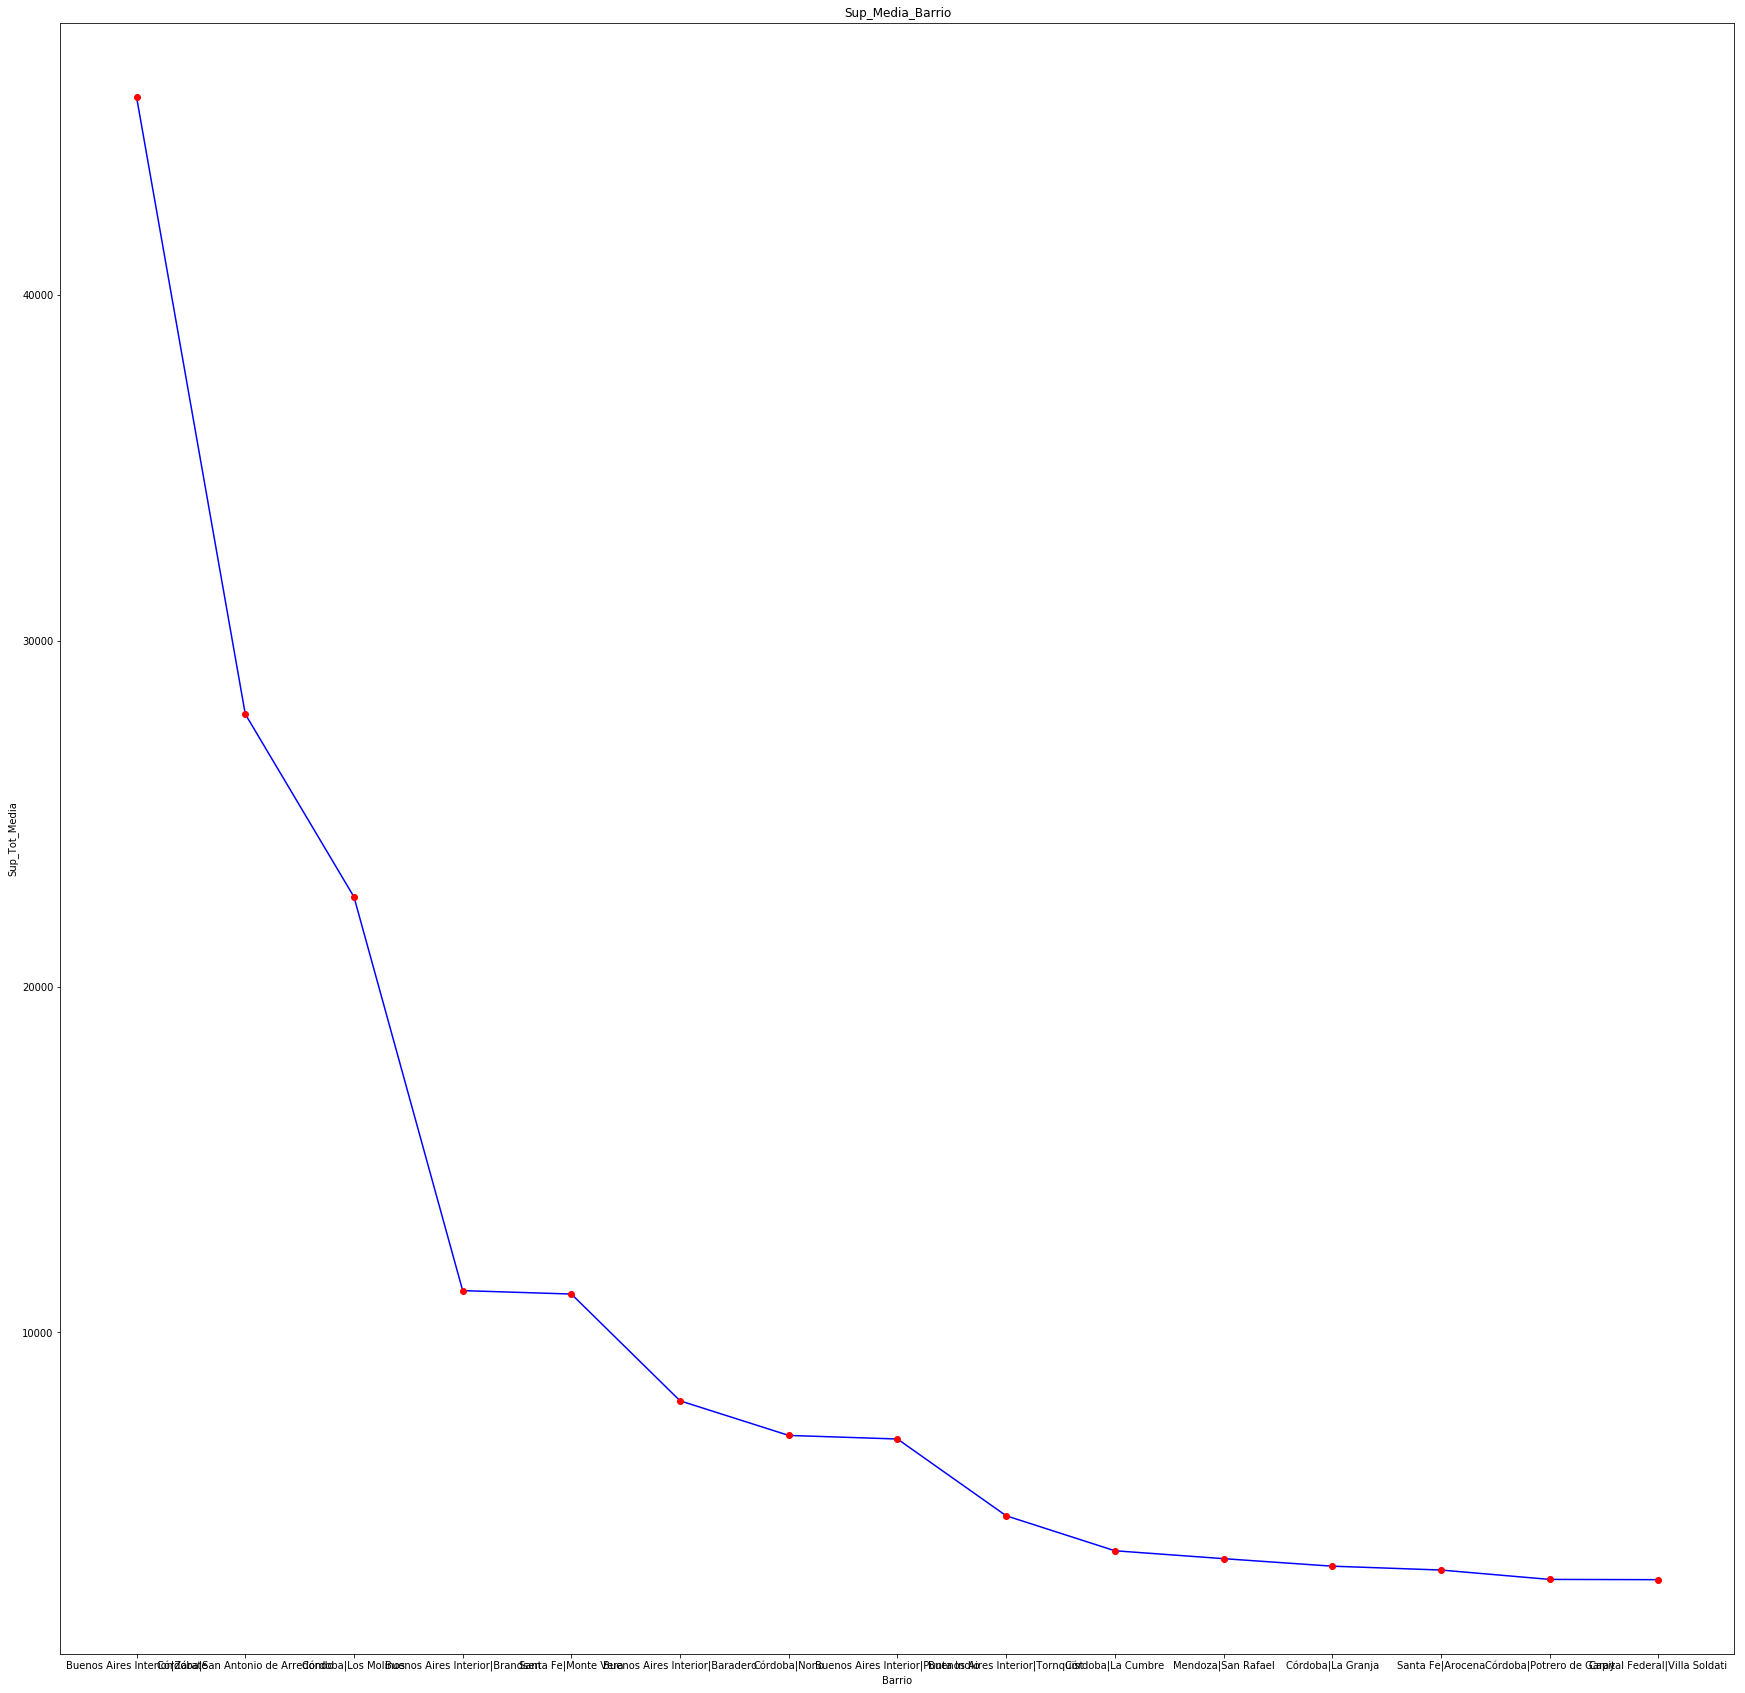

In [65]:
ancho = 30
alto  = 30

plt.figure( figsize = (ancho, alto))
plt.plot(place_mean.head(15), 'b', lw=1.5)
plt.plot(place_mean.head(15), 'ro')

plt.grid(False)

plt.axis('tight')
plt.xlabel('Barrio')
plt.ylabel('Sup_Tot_Media')
plt.title('Sup_Media_Barrio')
;

''

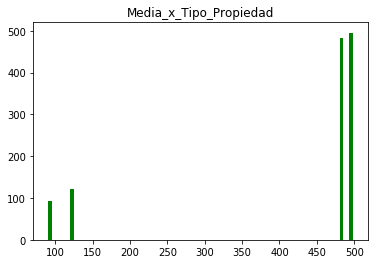

In [66]:
## VER COM AGREGAR LABELS
ancho = 30
alto  = 30

proper_mean = df[~df.discard].groupby('property_type')['surface_total_in_m2'].mean().sort_values(ascending = False)

plt.bar(proper_mean.head(), proper_mean, width=5,
        color='g')
        
plt.grid(False)


plt.axis('tight')
plt.title('Media_x_Tipo_Propiedad')
;

#ax.annotate('local maximum', xy=(2*np.pi, 1), xytext=(10, 4),
#            arrowprops={'facecolor':'black', 'shrink': 0.5})

#ax.annotate('local minimum', xy=(5 * np.pi, -1), xytext=(2, -6),
 #           arrowprops = {'arrowstyle' : '->',
  #                        'connectionstyle' : 'angle3,angleA=0,angleB=90'});
# opción b: 
# Asociado con los ejes, en proporciones de los ejes: 
#(0,0) es el limite inferior izquierdo y (1,1) el superior derecho
#ax.text(0.5, 0.1, ". Axes: (0.5, 0.1)", transform=ax.transAxes)

In [67]:
df[~df.discard].groupby(['property_type','state_local_name'])['surface_total_in_m2'].median()

property_type  state_local_name                            
PH             Bs.As. G.B.A. Zona Norte|Escobar                 129.0
               Bs.As. G.B.A. Zona Norte|General San Martín      100.0
               Bs.As. G.B.A. Zona Norte|José C Paz              356.0
               Bs.As. G.B.A. Zona Norte|Malvinas Argentinas      85.0
               Bs.As. G.B.A. Zona Norte|Pilar                   117.5
               Bs.As. G.B.A. Zona Norte|San Fernando            120.0
               Bs.As. G.B.A. Zona Norte|San Isidro              102.0
               Bs.As. G.B.A. Zona Norte|San Miguel               53.0
               Bs.As. G.B.A. Zona Norte|Tigre                   131.0
               Bs.As. G.B.A. Zona Norte|Vicente López            90.0
               Bs.As. G.B.A. Zona Oeste|General Rodríguez       116.0
               Bs.As. G.B.A. Zona Oeste|Hurlingham              117.5
               Bs.As. G.B.A. Zona Oeste|Ituzaingó               100.0
               Bs.As. G.B.A. Z

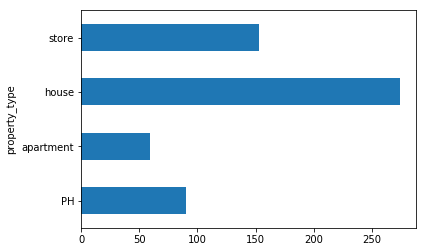

In [68]:
#VER COMO AGREGAR LABEL
df[~df.discard].groupby(['property_type'])['surface_total_in_m2'].median().plot(kind='barh')
#ax.annotate('local maximum', xy=(2*np.pi, 1), xytext=(10, 4),
#            arrowprops={'facecolor':'black', 'shrink': 0.5})

#ax.annotate('local minimum', xy=(5 * np.pi, -1), xytext=(2, -6),
 #           arrowprops = {'arrowstyle' : '->',
  #                        'connectionstyle' : 'angle3,angleA=0,angleB=90'});
# opción b: 
# Asociado con los ejes, en proporciones de los ejes: 
#(0,0) es el limite inferior izquierdo y (1,1) el superior derecho
#ax.text(0.5, 0.1, ". Axes: (0.5, 0.1)", transform=ax.transAxes)

In [69]:
df[~df.discard].groupby('state_local_name')['surface_total_in_m2'].median().describe().sort_values(ascending = False)

max      26597.500000
std       2043.721146
mean       492.613497
75%        339.750000
count      326.000000
50%        181.500000
25%         82.000000
min         10.000000
Name: surface_total_in_m2, dtype: float64

<function matplotlib.pyplot.show(*args, **kw)>

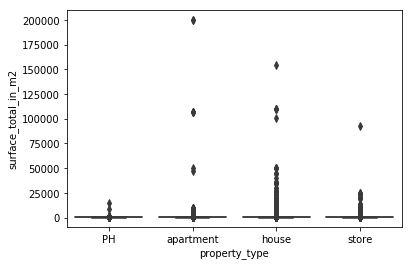

In [70]:
sea.boxplot(x = 'property_type', y = 'surface_total_in_m2', data = df, orient ='v', color='c') 
plt.show

In [71]:
pd.pivot_table(df[~df.discard], values = ['surface_total_in_m2'], index = ['state_local_name'], columns = ['property_type'],aggfunc = np.mean)

surface_total_in_m2              \
property_type                                                 PH   apartment   
state_local_name                                                               
Bs.As. G.B.A. Zona Norte|Escobar                      111.000000   69.217949   
Bs.As. G.B.A. Zona Norte|General San Martín           111.084577   69.468599   
Bs.As. G.B.A. Zona Norte|José C Paz                   334.875000   90.380952   
Bs.As. G.B.A. Zona Norte|Malvinas Argentinas           86.000000   80.940000   
Bs.As. G.B.A. Zona Norte|Pilar                        117.500000   83.555825   
Bs.As. G.B.A. Zona Norte|San Fernando                 123.473684   73.301663   
Bs.As. G.B.A. Zona Norte|San Isidro                   114.102804   94.912903   
Bs.As. G.B.A. Zona Norte|San Miguel                    71.000000   54.390658   
Bs.As. G.B.A. Zona Norte|Tigre                        187.705882   89.278582   
Bs.As. G.B.A. Zona Norte|Vicente López                104.711712  100.069405   
Bs.As. G.B.A. Zona Oeste|General Rodríguez            116.000000  212.857143   
Bs.As. G.B.A. Zona Oeste|Hurlingham                   117.500000   61.875000   
Bs.As. G.B.A. Zona Oeste|Ituzaingó                    111.400000   76.112245   
Bs.As. G.B.A. Zona Oeste|La Matanza                    98.564246   61.397163   
Bs.As. G.B.A. Zona Oeste|Marcos Paz                    76.000000   81.000000   
Bs.As. G.B.A. Zona Oeste|Merlo                         96.571429   56.846154   
Bs.As. G.B.A. Zona Oeste|Moreno                       170.000000  111.464912   
Bs.As. G.B.A. Zona Oeste|Morón                        114.431507   59.157576   
Bs.As. G.B.A. Zona Oeste|Tres de Febrero              141.631068   60.543478   
Bs.As. G.B.A. Zona Sur|Almirante Brown                100.473684   77.154321   
Bs.As. G.B.A. Zona Sur|Avellaneda                     113.200000   60.637394   
Bs.As. G.B.A. Zona Sur|Berazategui                           NaN   78.351351   
Bs.As. G.B.A. Zona Sur|Cañuelas                              NaN   44.500000   
Bs.As. G.B.A. Zona Sur|Esteban Echeverría             114.000000  160.191781   
Bs.As. G.B.A. Zona Sur|Ezeiza                          52.500000  154.277027   
Bs.As. G.B.A. Zona Sur|Florencio Varela                64.000000   54.000000   
Bs.As. G.B.A. Zona Sur|La Plata                       140.508197   76.722287   
Bs.As. G.B.A. Zona Sur|Lanús                          113.796748   75.817204   
Bs.As. G.B.A. Zona Sur|Lomas de Zamora                116.919355   68.516867   
Bs.As. G.B.A. Zona Sur|Presidente Perón                      NaN   41.000000   
...                                                          ...         ...   
Santa Fe|Capitán Bermúdez                                    NaN   65.000000   
Santa Fe|Coronda                                             NaN         NaN   
Santa Fe|Funes                                               NaN         NaN   
Santa Fe|Granadero Baigorria                                 NaN  102.000000   
Santa Fe|Gálvez                                              NaN   90.000000   
Santa Fe|Ibarlucea                                           NaN         NaN   
Santa Fe|Iriondo                                             NaN         NaN   
Santa Fe|Las Parejas                                         NaN         NaN   
Santa Fe|Las Rosas                                           NaN         NaN   
Santa Fe|Los Laureles                                        NaN   84.000000   
Santa Fe|Monte Vera                                          NaN         NaN   
Santa Fe|Rafaela                                       42.000000   49.428571   
Santa Fe|Reconquista                                         NaN         NaN   
Santa Fe|Recreo                                              NaN         NaN   
Santa Fe|Roldán                                       180.000000  106.000000   
Santa Fe|Rosario                                       79.761905   74.806983   
Santa Fe|San Carlos Centro                   

Veo los nulos

In [72]:
df['surface_total_in_m2'].\
fillna(value=df['surface_covered_in_m2']\
       [~df.discard & (df.property_type == 'apartment') & df.surface_total_in_m2.isnull() & ~df.surface_covered_in_m2.isnull()],\
       inplace = True)
df['surface_total_in_m2'].isnull().sum()

26252

Redujo un un 35% los nulos

Segunda manera, calculo la superficie_total_in_m2 usando la columna price y la columna

In [73]:
df.surface_total_in_m2.fillna(value=df.price/df.price_per_m2, inplace = True)
df.surface_total_in_m2.isnull().sum()

14078

Redujo casi un 50% de lo que restaba

Último método: reemplazo los nulos por el valor de la mediana del property_type por state_local_name en los casos que exista dicho valor. No uso el promedio porque es una variable muy sensible, entonces en caso que ingrese alguna propiedad outlier va a modificar bastante esta métrica.

Para ello, primero defino un nuevo DF que será una pivot table agrupada por propety_type y state_local_name

In [74]:
prop_place_median = pd.pivot_table(df[~df.discard], values='surface_total_in_m2', index='state_local_name', columns='property_type',\
                                   aggfunc=np.median, fill_value=0)
prop_place_median.head(20)

property_type,PH,apartment,house,store
state_local_name,,,,
Bs.As. G.B.A. Zona Norte|Escobar,123.0,57.0,217.0,42.0
Bs.As. G.B.A. Zona Norte|General San Martín,92.0,55.0,190.0,317.0
Bs.As. G.B.A. Zona Norte|José C Paz,353.0,38.0,245.0,185.0
Bs.As. G.B.A. Zona Norte|Malvinas Argentinas,85.0,78.0,318.0,210.0
Bs.As. G.B.A. Zona Norte|Pilar,95.0,69.0,280.0,86.5
Bs.As. G.B.A. Zona Norte|San Fernando,88.5,59.0,225.0,100.5
Bs.As. G.B.A. Zona Norte|San Isidro,95.0,79.0,296.0,140.0
Bs.As. G.B.A. Zona Norte|San Miguel,41.0,41.0,265.0,150.0
Bs.As. G.B.A. Zona Norte|Tigre,116.0,73.0,290.0,99.0


In [75]:
def sup_tot_est(row):
    try:
    #for index, row in p[ p.surface_total_in_m2.isnull() ].iterrows():
        if np.isnan(row.surface_total_in_m2):
            avg_surface = prop_place_median.loc[row.state_local_name][row.property_type]
            result = avg_surface
        else: 
            result = row.surface_total_in_m2
    
        return result
    except:
        pass

In [76]:
df['surface_total_in_m2'] = df.apply(sup_tot_est, axis = 1)

In [77]:
df.surface_total_in_m2.isnull().sum()

332

In [78]:
print('Nulos iniciales: 39.328')
print('Nulos actuales: ',df[~df.discard].surface_total_in_m2.isnull().sum())
print('Relación nulos: ',round(df[~df.discard].surface_total_in_m2.isnull().sum()/39328*100,2),'%')

Nulos iniciales: 39.328
Nulos actuales:  41
Relación nulos:  0.1 %


In [79]:
df['discard'] = ((df.discard) | (df.surface_total_in_m2.isnull()))

In [80]:
df[~df.discard].surface_covered_in_m2.isnull().sum()

18323

In [81]:
df['surface_covered_in_m2'].\
fillna(value=df['surface_total_in_m2']\
       [(df.property_type == 'apartment') & (df.surface_total_in_m2.isnull()==False) & (df.surface_covered_in_m2.isnull()==True)],\
       inplace = True)
df['surface_covered_in_m2'].isnull().sum()

8656

In [82]:
print('Redujo: ',round(df.surface_covered_in_m2.isnull().sum()/18323*100,2),'%')

Redujo:  47.24 %


In [83]:
cov_place_median = pd.pivot_table(df[~df.discard], values='surface_covered_in_m2', index='state_local_name', columns='property_type',\
                                   aggfunc=np.median, fill_value=0)
cov_place_median.head(20)

property_type,PH,apartment,house,store
state_local_name,,,,
Bs.As. G.B.A. Zona Norte|Escobar,68.0,57.0,180.0,42.0
Bs.As. G.B.A. Zona Norte|General San Martín,74.5,55.0,145.5,350.0
Bs.As. G.B.A. Zona Norte|José C Paz,74.0,38.0,124.0,160.0
Bs.As. G.B.A. Zona Norte|Malvinas Argentinas,85.0,61.0,256.0,300.0
Bs.As. G.B.A. Zona Norte|Pilar,95.0,55.0,220.0,100.0
Bs.As. G.B.A. Zona Norte|San Fernando,82.0,56.0,182.0,120.0
Bs.As. G.B.A. Zona Norte|San Isidro,80.0,71.0,240.0,158.0
Bs.As. G.B.A. Zona Norte|San Miguel,40.0,41.0,166.0,180.0
Bs.As. G.B.A. Zona Norte|Tigre,94.0,63.0,220.0,90.0


In [84]:
def sup_cov_est(row):
    try:
    #for index, row in p[ p.surface_total_in_m2.isnull() ].iterrows():
        if np.isnan(row.surface_total_in_m2):
            avg_surface = cov_place_median.loc[row.state_local_name][row.property_type]
            result = avg_surface
        else: 
            result = row.surface_total_in_m2
    
        return result
    except:
        pass

In [85]:
df['surface_covered_in_m2'] = df.apply(sup_cov_est, axis = 1)

In [86]:
df[~df.discard].surface_covered_in_m2.isnull().sum()

0

In [87]:
print('Nulos iniciales: 39.328')
print('Nulos actuales: ',df[~df.discard].surface_covered_in_m2.isnull().sum())
print('Relación nulos: ',round(df[~df.discard].surface_covered_in_m2.isnull().sum()/18359*100,2),'%')

Nulos iniciales: 39.328
Nulos actuales:  0
Relación nulos:  0.0 %


In [88]:
print('Ambos: ',((df[~df.discard].surface_covered_in_m2.isnull())&(df[~df.discard].surface_total_in_m2.isnull())).sum())

Ambos:  0


In [89]:
df[~df.discard].property_type[(df.surface_covered_in_m2.isnull())&(df.surface_total_in_m2.isnull())].count()

0

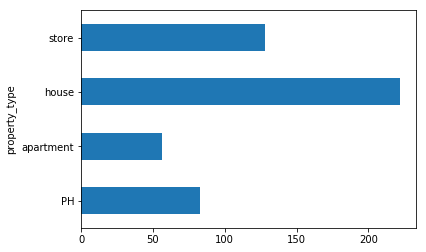

In [90]:
df[~df.discard].groupby(['property_type'])['surface_total_in_m2'].median().plot(kind='barh')

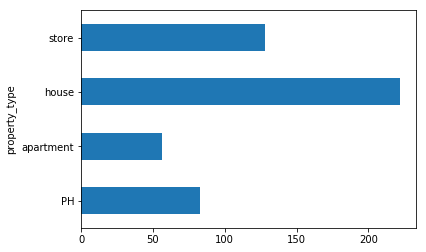

In [91]:
df[~df.discard].groupby(['property_type'])['surface_covered_in_m2'].median().plot(kind='barh')

In [92]:
df[~df.discard][['surface_total_in_m2','surface_covered_in_m2']].isnull().sum()

surface_total_in_m2      0
surface_covered_in_m2    0
dtype: int64

# VER COMO GRAFICAR LOS CASOS EN QUE AMBAS COLUMNAS SON NULAS POR TIPO DE PROPIEDAD

Comienzo de análisis de Floor y rooms

In [93]:
df[~df.discard].floor.isnull().sum()

108340

In [94]:
totales = df[~df.discard].floor.sum()
nulos = df[~df.discard].floor.isnull().sum()

diferencia = totales - nulos
diferencia 

29255.0

In [95]:
df[~df.discard].groupby("property_type")["floor"].sum().sort_values(ascending = False)

property_type
apartment    113901.0
house         21357.0
PH             2162.0
store           175.0
Name: floor, dtype: float64

Se supone que PH, store y house se encuentran todos en planta baja

In [96]:
#Se asigna planta baja a los valores dentro de PH, casa y store
#Si es Property_type :PH, Casa o Store => Se le imputa el valor 0.0. 

#Obtengo una lista con todos los valores que no son deptos en 0. 
resultado = df.apply(lambda x: x.floor if x.property_type == "apartment" else 0, axis = 1)


#Ahora la tengo que asignar a la columna floor para reemplazar los datos antiguos. 
df.floor = resultado
        

In [97]:
#Se chequea que los floor de PH, store o house esten en 0
df[~df.discard].head(5)

,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,...,cochera,country,completo,nameGeoPos,provGeoPos,localGeoPos,local1,local2,discard,state_local_name
0,0,sell,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787,"-34.6618237,-58.5088387",-34.661824,...,NaN,NaN,0,Mataderos,Capital Federal,Comuna 9,,,False,Capital Federal|Mataderos
1,1,sell,apartment,La Plata,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|,Argentina,Bs.As. G.B.A. Zona Sur,3432039,"-34.9038831,-57.9643295",-34.903883,...,1.0,NaN,0,La Plata,Buenos Aires,La Plata,,,False,Bs.As. G.B.A. Zona Sur|La Plata
2,2,sell,apartment,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787,"-34.6522615,-58.5229825",-34.652262,...,NaN,NaN,0,Mataderos,Capital Federal,Comuna 9,,,False,Capital Federal|Mataderos
3,3,sell,PH,Liniers,|Argentina|Capital Federal|Liniers|,Argentina,Capital Federal,3431333,"-34.6477969,-58.5164244",-34.647797,...,NaN,NaN,0,Liniers,Capital Federal,Comuna 9,,,False,Capital Federal|Liniers
4,4,sell,apartment,Centro,|Argentina|Buenos Aires Costa Atlántica|Mar del Plata|Centro|,Argentina,Buenos Aires Costa Atlántica,3435548,"-38.0026256,-57.5494468",-38.002626,...,NaN,NaN,0,NaN,NaN,NaN,Mar del Plata,,False,Buenos Aires Costa Atlántica|Mar del Plata


In [98]:
df[~df.discard].groupby("property_type")["floor"].sum().sort_values(ascending = False)

property_type
apartment    113901.0
store             0.0
house             0.0
PH                0.0
Name: floor, dtype: float64

In [99]:
df[~df.discard].floor.isnull().sum()

61520

In [100]:
g = df[~df.discard].groupby("property_type")
g["floor"].max()

property_type
PH              0.0
apartment    2509.0
house           0.0
store           0.0
Name: floor, dtype: float64

Se comienza a trabajar con departamentos

In [101]:
#Se busca en descripcion los pisos de los deptos, para reducir na y corregir datos mal ingresados por columna
#Quiero recorrer la lista de pisos ya modificada y asignarle el valor de piso_desc en caso de que sea un aparment con floor nan. 

#condition = (df.property_type[x] == "apartment" and pd.isnull(df["floor"][x]))
pisos_comb = [piso_desc[x] if pd.isnull(df["floor"][x]) else df.floor[x] for x in range(len(df.floor))]

#print (pisos_comb[170])
df.floor = pisos_comb

In [102]:
#Se chequea el valor de floor de la fila 170 sea 4.0 
df[~df.discard].head(171)

,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,...,cochera,country,completo,nameGeoPos,provGeoPos,localGeoPos,local1,local2,discard,state_local_name
0,0,sell,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787,"-34.6618237,-58.5088387",-34.661824,...,NaN,NaN,0,Mataderos,Capital Federal,Comuna 9,,,False,Capital Federal|Mataderos
1,1,sell,apartment,La Plata,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|,Argentina,Bs.As. G.B.A. Zona Sur,3432039,"-34.9038831,-57.9643295",-34.903883,...,1.0,NaN,0,La Plata,Buenos Aires,La Plata,,,False,Bs.As. G.B.A. Zona Sur|La Plata
2,2,sell,apartment,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787,"-34.6522615,-58.5229825",-34.652262,...,NaN,NaN,0,Mataderos,Capital Federal,Comuna 9,,,False,Capital Federal|Mataderos
3,3,sell,PH,Liniers,|Argentina|Capital Federal|Liniers|,Argentina,Capital Federal,3431333,"-34.6477969,-58.5164244",-34.647797,...,NaN,NaN,0,Liniers,Capital Federal,Comuna 9,,,False,Capital Federal|Liniers
4,4,sell,apartment,Centro,|Argentina|Buenos Aires Costa Atlántica|Mar del Plata|Centro|,Argentina,Buenos Aires Costa Atlántica,3435548,"-38.0026256,-57.5494468",-38.002626,...,NaN,NaN,0,NaN,NaN,NaN,Mar del Plata,,False,Buenos Aires Costa Atlántica|Mar del Plata
5,5,sell,house,Gualeguaychú,|Argentina|Entre Ríos|Gualeguaychú|,Argentina,Entre Ríos,3433657,"-33.0140714,-58.519828",-33.014071,...,NaN,NaN,0,Gualeguaychú,Entre Ríos,Gualeguaychú,,,False,Entre Ríos|Gualeguaychú
6,6,sell,PH,Munro,|Argentina|Bs.As. G.B.A. Zona Norte|Vicente López|Munro|,Argentina,Bs.As. G.B.A. Zona Norte,3430511,"-34.5329567,-58.5217825",-34.532957,...,NaN,NaN,0,Munro,Buenos Aires,Vicente López,Vicente López,,False,Bs.As. G.B.A. Zona Norte|Vicente López
7,7,sell,apartment,Belgrano,|Argentina|Capital Federal|Belgrano|,Argentina,Capital Federal,3436077,"-34.5598729,-58.443362",-34.559873,...,NaN,NaN,0,Belgrano,Capital Federal,Comuna 13,,,False,Capital Federal|Belgrano
8,8,sell,apartment,Belgrano,|Argentina|Capital Federal|Belgrano|,Argentina,Capital Federal,3436077,"-34.5598729,-58.443362",-34.559873,...,NaN,NaN,0,Belgrano,Capital Federal,Comuna 13,,,False,Capital Federal|Belgrano
9,9,sell,house,Rosario,|Argentina|Santa Fe|Rosario|,Argentina,Santa Fe,3838574,"-32.942031,-60.7259192",-32.942031,...,NaN,NaN,0,Rosario,Santa Fe,Rosario Department,,,False,Santa Fe|Rosario


In [103]:
df[~df.discard].groupby("property_type")["floor"].sum().sort_values(ascending = False)

property_type
apartment    148174.0
store             0.0
house             0.0
PH                0.0
Name: floor, dtype: float64

In [104]:
df[~df.discard].floor.isnull().sum()

57781

In [105]:
df[~df.discard].groupby("floor")["floor"].count()

floor
0.0       48165
1.0        1823
2.0        1419
3.0        1130
4.0         959
5.0         581
6.0         697
7.0         507
8.0         431
9.0         379
10.0        416
11.0        275
12.0        251
13.0        180
14.0        132
15.0        208
16.0        107
17.0         60
18.0        104
19.0         52
20.0         27
21.0         32
22.0         23
23.0         17
24.0         21
25.0         15
26.0          4
27.0         19
28.0         33
29.0         15
          ...  
905.0         2
906.0         1
907.0         3
908.0         2
910.0         1
1001.0        1
1104.0        2
1106.0        1
1109.0        1
1201.0        1
1202.0        1
1204.0        1
1206.0        1
1208.0        1
1301.0        1
1304.0        1
1305.0        1
1306.0        1
1401.0        1
1403.0        1
1404.0        1
1407.0        1
1504.0        2
1602.0        1
1606.0        1
1607.0        1
1608.0        2
1609.0        4
2103.0        1
2509.0        1
Name: floor, Lengt

In [106]:
#Para departamentos tomar el primer digito de los edificios mayores a 40 pisos.
#En todo caso supongo que se trata de un error de tipeo, y se busco ingresar piso 6, depto 7en lugar de 67


#Hago una lista que guarde los primeros 2 digitos de todos los edificios mayores a 40 pisos.
lista_pisos = [(int(str(df["floor"][x])[:2])) for x in range(len(df.floor)) if df["floor"][x] > 50]

#Cuento los elementos de la lista, para ver si es significativo o simplemente puede eliminar los outliers
len(lista_pisos)

#Como son solo 173 registros, decido eliminar estos outliers
df =  df[(df['floor'] < 50 ) | (pd.isnull(df['floor']))]

In [107]:
df[~df.discard].head(5)

,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,...,cochera,country,completo,nameGeoPos,provGeoPos,localGeoPos,local1,local2,discard,state_local_name
0,0,sell,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787,"-34.6618237,-58.5088387",-34.661824,...,NaN,NaN,0,Mataderos,Capital Federal,Comuna 9,,,False,Capital Federal|Mataderos
1,1,sell,apartment,La Plata,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|,Argentina,Bs.As. G.B.A. Zona Sur,3432039,"-34.9038831,-57.9643295",-34.903883,...,1.0,NaN,0,La Plata,Buenos Aires,La Plata,,,False,Bs.As. G.B.A. Zona Sur|La Plata
2,2,sell,apartment,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787,"-34.6522615,-58.5229825",-34.652262,...,NaN,NaN,0,Mataderos,Capital Federal,Comuna 9,,,False,Capital Federal|Mataderos
3,3,sell,PH,Liniers,|Argentina|Capital Federal|Liniers|,Argentina,Capital Federal,3431333,"-34.6477969,-58.5164244",-34.647797,...,NaN,NaN,0,Liniers,Capital Federal,Comuna 9,,,False,Capital Federal|Liniers
4,4,sell,apartment,Centro,|Argentina|Buenos Aires Costa Atlántica|Mar del Plata|Centro|,Argentina,Buenos Aires Costa Atlántica,3435548,"-38.0026256,-57.5494468",-38.002626,...,NaN,NaN,0,NaN,NaN,NaN,Mar del Plata,,False,Buenos Aires Costa Atlántica|Mar del Plata


In [108]:
#Se chequea que no haya pisos mayores a 49. 
df.groupby("floor")["floor"].count()

floor
0.0     50155
1.0      1863
2.0      1444
3.0      1152
4.0       966
5.0       587
6.0       705
7.0       515
8.0       443
9.0       388
10.0      419
11.0      279
12.0      262
13.0      190
14.0      143
15.0      211
16.0      107
17.0       61
18.0      107
19.0       54
20.0       27
21.0       32
22.0       23
23.0       17
24.0       21
25.0       15
26.0        4
27.0       19
28.0       33
29.0       15
30.0        4
31.0        5
32.0        6
33.0        9
34.0       10
35.0       12
36.0        3
37.0        4
38.0        2
39.0        2
40.0        7
41.0        4
42.0        2
43.0        1
44.0        2
45.0        6
46.0        6
47.0        2
48.0        3
49.0        3
Name: floor, dtype: int64

LUEGO DE LA PRESENTACIÓN DECIDIMOS DEJAR COMENTADO ESTE PASO.

Reemplazo los nulos por el valor de la mediana de rooms por place_name en los casos que exista dicho valor. 

Para ello, primero defino un nuevo DF que será una pivot table agrupada por propety_type y place_name

In [109]:
# Los na de los departamentos se completan con la mediana de departamentos, por zona.
                                   
df_floor_median = pd.pivot_table(df, values='floor', index='place_name', columns='property_type',\
                                   aggfunc=np.median, fill_value=0)
df_floor_median.head(20)

property_type,PH,apartment,house,store
place_name,,,,
9 de Abril,0,0.0,0,0
Abasto,0,3.5,0,0
Abril Club de Campo,0,0.0,0,0
Acacias Blancas,0,0.0,0,0
Acassuso,0,3.0,0,0
Achiras,0,0.0,0,0
Adolfo Alsina,0,0.0,0,0
Adrogué,0,2.0,0,0
Aeropuerto Internacional Ezeiza,0,0.0,0,0


In [110]:
def floor_est(row):
    try:
    #for index, row in p[ p.surface_total_in_m2.isnull() ].iterrows():
        if np.isnan(row.floor):
            avg_floor = df_floor_median.loc[row.place_name][row.property_type]
            result = avg_floor
        else: 
            result = row.floor
    
        return result
    except:
        pass

In [111]:
#Se comenta el reemplazo de los deptos nulos por la mediana de pisos por tipo de barrio. 
#df['floor'] = df.apply(floor_est, axis = 1)

In [112]:
#Quedarían 110 valores nulos, en caso de no comentar el codigo anterior. 
df[~df.discard]['floor'].isnull().sum()

57781

Rooms

In [113]:
df[~df.discard].rooms.isnull().sum()   ### cuantos registros tienen nulo campo rooms

69256

In [114]:
df[~df.discard].groupby("rooms")["rooms"].count()    ### cantidad registros x cantidad de rooms

rooms
1.0      7323
2.0     12284
3.0     12367
4.0      7820
5.0      3717
6.0      1373
7.0       747
8.0       393
9.0       171
10.0      218
11.0       64
12.0       63
13.0       33
14.0       26
15.0       24
16.0       11
17.0       16
18.0        6
19.0        4
20.0       11
21.0        5
22.0        8
23.0        2
24.0        1
25.0        4
27.0        1
28.0        1
29.0        1
30.0        2
31.0        1
32.0        3
Name: rooms, dtype: int64

In [115]:
df[~df.discard]["rooms"].max()

32.0

In [116]:
#Sacar de descripción. 

rooms_combinado = [rooms_desc[x] if pd.isnull(df.rooms[x]) else df.rooms[x] for x in range(len(df.rooms))]

#df.rooms = rooms_desc
df.rooms = rooms_combinado

In [117]:
df[~df.discard].head(5)

,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,...,cochera,country,completo,nameGeoPos,provGeoPos,localGeoPos,local1,local2,discard,state_local_name
0,0,sell,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787,"-34.6618237,-58.5088387",-34.661824,...,NaN,NaN,0,Mataderos,Capital Federal,Comuna 9,,,False,Capital Federal|Mataderos
1,1,sell,apartment,La Plata,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|,Argentina,Bs.As. G.B.A. Zona Sur,3432039,"-34.9038831,-57.9643295",-34.903883,...,1.0,NaN,0,La Plata,Buenos Aires,La Plata,,,False,Bs.As. G.B.A. Zona Sur|La Plata
2,2,sell,apartment,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787,"-34.6522615,-58.5229825",-34.652262,...,NaN,NaN,0,Mataderos,Capital Federal,Comuna 9,,,False,Capital Federal|Mataderos
3,3,sell,PH,Liniers,|Argentina|Capital Federal|Liniers|,Argentina,Capital Federal,3431333,"-34.6477969,-58.5164244",-34.647797,...,NaN,NaN,0,Liniers,Capital Federal,Comuna 9,,,False,Capital Federal|Liniers
4,4,sell,apartment,Centro,|Argentina|Buenos Aires Costa Atlántica|Mar del Plata|Centro|,Argentina,Buenos Aires Costa Atlántica,3435548,"-38.0026256,-57.5494468",-38.002626,...,NaN,NaN,0,NaN,NaN,NaN,Mar del Plata,,False,Buenos Aires Costa Atlántica|Mar del Plata


In [118]:
df[~df.discard].rooms.isnull().sum()    #### cuantos nulos quedaron

48983

Reemplazo los nulos por el valor de la mediana de rooms del property_type por place_name en los casos que exista dicho valor. 

Para ello, primero defino un nuevo DF que será una pivot table agrupada por propety_type y place_name

In [119]:
df_room_median = pd.pivot_table(df, values='rooms', index='place_name', columns='property_type',\
                                   aggfunc=np.median, fill_value=0)
df_room_median.head(20)

property_type,PH,apartment,house,store
place_name,,,,
9 de Abril,0.0,0.0,5.0,0.0
Abasto,4.0,3.0,4.0,2.5
Abril Club de Campo,0.0,0.0,3.0,0.0
Acacias Blancas,0.0,0.0,4.0,0.0
Acassuso,5.0,3.0,3.0,3.0
Achiras,0.0,1.0,2.0,1.0
Adolfo Alsina,0.0,0.0,3.0,0.0
Adrogué,2.0,3.0,3.0,3.0
Aeropuerto Internacional Ezeiza,0.0,0.0,1.0,0.0


Defino una función que reemplace celda por celda los nulos por la mediana del property_type por place_name

In [120]:
def rooms_est(row):
    try:
    #for index, row in p[ p.surface_total_in_m2.isnull() ].iterrows():
        if np.isnan(row.rooms):
            avg_rooms = df_room_median.loc[row.place_name][row.property_type]
            result = avg_rooms
        else: 
            result = row.rooms
    
        return result
    except:
        pass

In [121]:
df['rooms'] = df.apply(rooms_est, axis = 1)

In [122]:
df[~df.discard].head(5)

,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,...,cochera,country,completo,nameGeoPos,provGeoPos,localGeoPos,local1,local2,discard,state_local_name
0,0,sell,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787,"-34.6618237,-58.5088387",-34.661824,...,NaN,NaN,0,Mataderos,Capital Federal,Comuna 9,,,False,Capital Federal|Mataderos
1,1,sell,apartment,La Plata,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|,Argentina,Bs.As. G.B.A. Zona Sur,3432039,"-34.9038831,-57.9643295",-34.903883,...,1.0,NaN,0,La Plata,Buenos Aires,La Plata,,,False,Bs.As. G.B.A. Zona Sur|La Plata
2,2,sell,apartment,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787,"-34.6522615,-58.5229825",-34.652262,...,NaN,NaN,0,Mataderos,Capital Federal,Comuna 9,,,False,Capital Federal|Mataderos
3,3,sell,PH,Liniers,|Argentina|Capital Federal|Liniers|,Argentina,Capital Federal,3431333,"-34.6477969,-58.5164244",-34.647797,...,NaN,NaN,0,Liniers,Capital Federal,Comuna 9,,,False,Capital Federal|Liniers
4,4,sell,apartment,Centro,|Argentina|Buenos Aires Costa Atlántica|Mar del Plata|Centro|,Argentina,Buenos Aires Costa Atlántica,3435548,"-38.0026256,-57.5494468",-38.002626,...,NaN,NaN,0,NaN,NaN,NaN,Mar del Plata,,False,Buenos Aires Costa Atlántica|Mar del Plata


In [123]:
df[~df.discard].rooms.isnull().sum()

108

Empiezo a trabajar con Currency

In [124]:
df.discard.value_counts()

False    115956
True       5086
Name: discard, dtype: int64

In [125]:
tc=pd.read_excel("A3500.xls") #cargo serie de tipo de cambio de BCRA

In [126]:
df[~df.discard].price.isnull().sum()   ## registros con price nulo

19202

In [127]:
df.currency.isnull().sum()    ## registros con currency nulo

20405

In [128]:
df.groupby('currency')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
currency,,,,,,,,
ARS,13204.0,1.795975e+06,1.968703e+06,80000.0,1.046638e+06,1418000.0,1980000.0,99999999.0
PEN,2.0,6.650000e+05,4.030509e+05,380000.0,5.225000e+05,665000.0,807500.0,950000.0
USD,87430.0,2.604767e+05,4.066298e+05,5000.0,1.000000e+05,160000.0,290000.0,46545445.0
UYU,1.0,6.500000e+08,NaN,650000000.0,6.500000e+08,650000000.0,650000000.0,650000000.0


In [129]:
df.discard = (df.discard) | ((df.currency == 'UYU') | (df.currency == 'PEN'))  #  " Elimina registro "

In [130]:
tc.Fecha.describe()

count                    4248
unique                   4248
top       2007-09-10 00:00:00
freq                        1
first     2002-03-04 00:00:00
last      2019-06-05 00:00:00
Name: Fecha, dtype: object

In [131]:
#obtengo media para el 1er semestre de 2017
tc_mean=tc['tipo_de_cambio'][(tc['Fecha']>"01-01-2017") & (tc['Fecha']<"06-01-2017")].mean() 

In [132]:
#construyo una funcion para llevar los que estan en ARS a USD
def price_inusd(row):
    if row.currency == "ARS":
        price = row.price/tc_mean
        result = price
    else: 
        result = row.price
    
    return result

In [133]:
df['price']=df.apply(price_inusd, axis = 1) #aplico la funcion a la columna price  

In [134]:
df['currency']="USD"   #ahora toda la columna currency esta expresada en usd

In [135]:
#construyo una tabla para obtener la mediana para precio por m2 por tipo de propiedad y ubicacion
prop_price_median = pd.pivot_table(df[~df.discard], values='price_per_m2', index='state_local_name', columns='property_type',\
                                   aggfunc=np.median, fill_value=0)

In [136]:
#funcion para calcular el precio en funcion del precio por m2 y la superficie total
def price_tot_est(row):  
    try:
        if np.isnan(row.price):
            
            avg_price = prop_price_median.loc[row.state_local_name][row.property_type]*row.surface_total_in_m2                                                                        
            result = avg_price
        else: 
            result = row.price
        return result
    except:
        pass

In [137]:
df['price']=df.apply(price_tot_est, axis = 1) # aplico la funcion  

In [138]:
df['price'].isnull().value_counts()

False    120276
True        766
Name: price, dtype: int64

In [139]:
df.to_csv('properatti2.csv', sep=',', index=False, encoding='UTF-8')